# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController
from pympc.geometry.polytope import Polytope

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 10000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.0
A_0 = np.array([[0., 1.],[g/l, 0.]])
B_0 = np.array([[0.],[1/(m*l**2.)]])
c_0 = np.array([[0.],[0.]])
S_0 = ds.DTAffineSystem.from_continuous(A_0, B_0, c_0, t_s, method)

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_1 = B_0
c_1 = np.array([[0.],[k*d/(m*l)]])
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# list of dynamics
S = [S_0, S_1]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state domain n.1
x_max_0 = np.array([[d/l], [1.5]])
x_min_0 = -np.array([[d/l*2.],[x_max_0[1,0]]])
X_0 = Polytope.from_bounds(x_min_0, x_max_0)
X_0.assemble()

# state domain n.2
x_min_1 = np.array([[x_max_0[0,0]], [x_min_0[1,0]]])
x_max_1 = -x_min_0
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# list of state domains
X = [X_0, X_1]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem.from_orthogonal_domains(S, X, U)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

Computation of MOAS started... MOAS found.
MOAS facets are 96, removing redundant ones... redundant factes removed, MOAS facets are 28.


We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.0],[.79]])
u = []
x = [x_0]
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

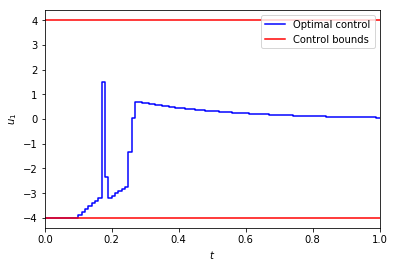

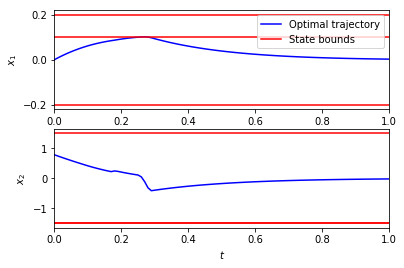

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_0, x_min_1, x_max_1))
plt.show()

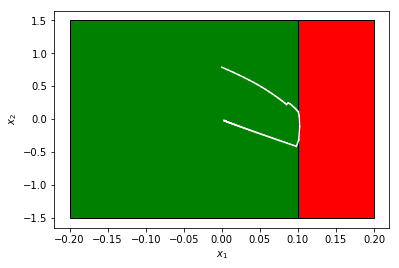

In [10]:
X_0.plot(facecolor='g')
X_1.plot(facecolor='r')
mpc_plt.state_space_trajectory(x, color='w')
plt.show()

In order to make computations faster, we can warm start the MIQP solver at each step time.

In [11]:
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
terminal_mode = 0
for k in range(N_sim):
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    x_next = pwa_sys.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [pwa_sys.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)